In [1]:
from lets_plot import *
from lets_plot.bistro import *
import pandas as pd


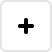
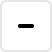
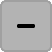
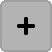
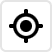
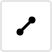
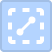
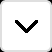
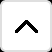
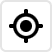
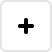
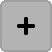
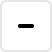
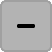
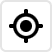
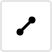
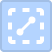
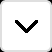
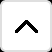
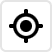

In [2]:
LetsPlot.setup_html()

In [3]:
df = pd.DataFrame({
    'x': [0.0, 4.0, 1.0, 5.0, 2.0, 6.0, 3.0, 7.0,  0.0, 4.0, 1.0, 5.0, 2.0, 6.0, 3.0, 7.0],
    'y': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    'h': [0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  0.0, 0.0, 2.0, 2.0, 0.0, 0.0, None, 0.0]
})

In [4]:
ggplot(df) + geom_area_ridges(aes("x", "y", height="h"), stat='identity')

In [5]:
def dataset_array_to_dataframe(dataset_array):
    df = pd.DataFrame.from_records([
        (j, i, a)
        for i, r in enumerate(dataset_array)
        for j, a in enumerate(r)
    ], columns=["x", "y", "h"])
    return df

def process_rows(df, *, dist=1, step_y=1):
    def add_tails_to_row(subdf, y):
        subdf = subdf.sort_values(by='x').copy()
        x_to_h = lambda x: subdf[subdf['x'] == x].iloc[0]['h'] if x in subdf['x'].values else 0
        series = []
        s = []
        last_pick = subdf['x'].min()
        for x in range(subdf['x'].min(), subdf['x'].max() + 1):
            h = x_to_h(x)
            if h > 0:
                s.append(x)
                last_pick = x
            elif x - last_pick >= dist and len(s) > 0:
                series.append(s)
                s = []
        if len(s) > 0:
            series.append(s)
        return pd.concat([
            pd.concat([
                pd.DataFrame({'x': s, 'y': [y] * len(s), 'h': [x_to_h(x) for x in s]}),
                pd.DataFrame({'x': [min(s) - 2, min(s) - 1, max(s) + 1, max(s) + 2], 'y': [y] * 4, 'h': [-1, 0, 0, -1]})
            ])
            for s in series
        ]).sort_values(by=['x', 'h'], ascending=[True, False])\
          .drop_duplicates(subset=['x'], keep='first')\
          .reset_index(drop=True)
    return pd.concat([
        add_tails_to_row(df[df['y'] == y], y) for y in range(df['y'].min(), df['y'].max() + 1, step_y)
    ]).sort_values(by=['y', 'x']).reset_index(drop=True)

In [6]:
raw_data_array = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/data/new_zealand.csv", header=None).to_numpy()
df = dataset_array_to_dataframe(raw_data_array)
min_h = df[df['h'] > 0].describe()['h']['min']
df = process_rows(df[df["h"] > 0], dist=25, step_y=2)
bbox = dict(xmin=df['x'].min(), ymin=df['y'].min(), xmax=df['x'].max(), ymax=df['y'].max())
df['h'] = df['h'].replace({-1.0: None})
print(df.shape)
df.head()

(4769, 3)


,x,y,h
0,431,6,None
1,432,6,0.0
2,433,6,114.518776
3,435,6,180.14386
4,436,6,0.0


In [7]:
ggplot(df) + \
    geom_area_ridges(aes("x", "y", height="h"), \
                     stat='identity', min_height=0, scale=.0025, \
                     color="#08519c", fill="#bdd7e7", \
                     sampling=sampling_pick(df.shape[0]), \
                     tooltips=layer_tooltips().line("height|@h").format("@h", ',.1~f'), \
                     show_legend=False) + \
    geom_text(x=bbox['xmin'] + .7 * (bbox['xmax'] - bbox['xmin']), \
              y=bbox['ymin'] + .9 * (bbox['ymax'] - bbox['ymin']), \
              label="New Zealand", size=25, family="Cinzel") + \
    scale_y_continuous(trans='reverse') + \
    ggsize(600, 600) + \
    theme_minimal() + \
    theme(axis='blank', panel_grid='blank', \
          plot_background=element_rect(color='black', fill='#e6e6e6', size=1))